In [1]:
import numpy as np
import ResonatorOptimizer as ro
import lmfit
from lmfit.models import BreitWignerModel,LinearModel
from matplotlib import pyplot as plt

In [119]:
class Sparams:
    def __init__(self,freq=0,Z0=50,length=1e-03,gamma=1,Ck=1e-15):
        self.__freq = freq
        self.__Z0 = Z0
        self.__l = length
        self.__gamma = gamma
        self.__Ck = Ck
        return
    
    def port(self):
        Zport = 1 / (1j*2*np.pi*self.__freq*self.__Ck)
        return [np.matrix(((1,Zport[i]),(0,1)),dtype=complex) for i in range(len(freq))]

    def transmission(self):
        t11 = np.cosh(self.__gamma*self.__l)
        t12 = self.__Z0 * np.sinh(self.__gamma*self.__l)
        t21 = (1/self.__Z0) * np.sinh(self.__gamma*self.__l)
        t22 = np.cosh(self.__gamma*self.__l)
        return [np.matrix(([t11[i],t12[i]],[t21[i],t22[i]]),dtype=complex) for i in range(len(gamma))]

    def transfer(self,inport,transmission,outport):
        return inport * transmission * outport
    
    def s21_from_abcd(self,abcd,Rload=50,format='db'):
        s21_mat = [self.get_s21(abcd_mat[i],Rload,format) for i in range(len(self.__freq))]
        s21 = np.array([complex(s21_mat[i]) for i in range(len(s21_mat))])
        return s21
    
    def s21(self,Rload=50,format='db'):
        inport = self.port()
        tr = self.transmission()
        outport = self.port()
        abcd_mat = [self.transfer(inport[i],tr[i],outport[i]) for i in range(len(self.__freq))]
        s21_mat = [self.get_s21(abcd_mat[i],Rload,format) for i in range(len(self.__freq))]
        s21 = np.array([complex(s21_mat[i]) for i in range(len(s21_mat))])
        return s21
    
    def get_s21(self,abcd,Rload,format):
        A = abcd.flat[0]
        B = abcd.flat[0]
        C = abcd.flat[0]
        D = abcd.flat[0]

        s21 = 2 / (A + (B/Rload) + C*Rload + D)

        if format == 'db':
            return 20*np.log10(s21)
        elif format == 'mag':
            return s21
        else:
            raise ValueError('The format specified is not recognized. Please choose either \'db\' or \'mag\'')

In [120]:
class ResonatorQuality:
    def __init__(self,freq,s21,length=1e-03,alpha=0):
        self.__freq = freq
        self.__s21 = s21
        self.__l = length
        self.__alpha = alpha
        return
    
    def Qint(self):
        return np.pi / (self.__alpha * 2 * self.__l)
    
    def Qext(self):
        return 1/(1/self.Qloaded() - 1/self.Qint())
    
    def Qloaded(self):
        rfit = ResonatorFitting()
        fit = rfit.LorentzianFit(self.__freq,self.__s21,plot=False)
        return fit.Q.values[0]
    
    def insertion_loss(self,format='db'):
        g = self.Qint()/self.Qext()
        if format == 'db':
            return -20*np.log10(g/(g+1))
        elif format == 'mag':
            return g/(g+1)
        else:
            raise ValueError('The format specified is not recognized. Please choose either \'db\' or \'mag\'')

In [121]:
import lmfit
from lmfit.models import BreitWignerModel,LinearModel
import pandas as pd

class ResonatorFitting:
    def __init__(self):
        return
    
    def LorentzianFit(self,freq,trace, plot = True):
        
        if np.any(np.iscomplex(trace)):
            trace = trace.real
        
        #print (len(trace))
        start,stop = None, None                                         #Specifies the window within the data to analyse.
        Lin_mod = LinearModel()                                         #Linear lmfit model for background offset and slope
        BW_mod = BreitWignerModel()                                     #Breit-Wigner-Fano model
        mod = BW_mod+Lin_mod
        
        x = freq[start:stop]/1E6                                        #Convert frequencies to MHz
        trace = (10**(trace/10))                                        #Convert decibel data to linear
        y = trace[start:stop]
        
        pars = BW_mod.guess(y, x=x)                                     #Initialize fit params
        pars += Lin_mod.guess(y,x=x, slope = 0, vary = False)           
        pars['center'].set(value=x[np.argmax(y)], vary=True, expr='')   #Find the highest transmission value. Corresponding frequency is used as a guess for the centre frequency
        pars['sigma'].set(value=0.05, vary=True, expr='')               #Linewidth
        pars['q'].set(value=0, vary=True, expr='')                      #Fano factor (asymmetry term). q=0 gives a Lorentzian
        pars['amplitude'].set(value=-0.03, vary=True, expr='')          #Amplitude

        out  = mod.fit(y,pars,x=x)
#         print (out.fit_report())
        #print (out.params['amplitude'],out.params['q'],out.params['sigma'])
        sigma = out.params['sigma']
        centre = out.params['center']
        
        dic = {'x':x,'y':y,'fit':out.best_fit,'out':out,'sigma':sigma.value,
               'centre':centre.value,'Q':centre.value/sigma.value}
        
        df = pd.DataFrame(data=dic)

        if plot == True:
            print(out.params['amplitude'],out.params['q'],out.params['sigma'])
            plt.plot(x,y, color = 'orange', label = 'Data')
            plt.plot(x, out.best_fit, color = 'darkslateblue',label = 'Fano resonance fit')

#         return(sigma.value,centre.value,centre.value/sigma.value)       #Returns linewidth in GHz, centre in GHz and Q factor
        return df

In [122]:
# Global Parameters
__er = 11.9
__fo = 7.3e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 100e-06
__length = 8102.64e-06
__width = 20e-06
__gap = .5*(__total_width-__width)
__Ck = 1e-15

freq = np.linspace(6.8,6.9,500)*1e09

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))

In [123]:
# Define a cpw 
cpw = ro.cpwCalcs(__width,__gap,__length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth)

# Gather phase parameters
alpha = cpw.alpha()
beta = cpw.beta(freq)
gamma = cpw.gamma(freq)

Z0 = cpw.impedance_kinetic()

sp = Sparams(freq=freq,gamma=gamma,length=__length,Z0=Z0,Ck=1e-15)
s21 = sp.s21(Rload=50,format='db')

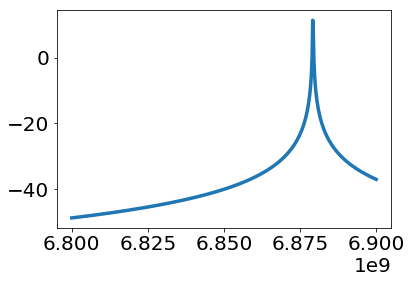

In [124]:
plt.plot(freq,s21)
plt.show()

<Parameter 'amplitude', 3.3786578955500825e-07, bounds=[-inf:inf]> <Parameter 'q', 120344.58115799997, bounds=[-inf:inf]> <Parameter 'sigma', 0.008250561046099891, bounds=[0.0:inf]>


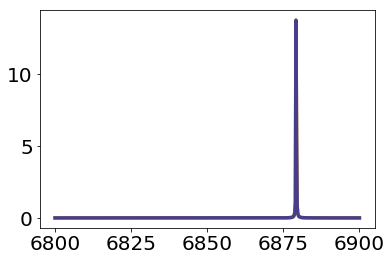

In [125]:
rfit = ResonatorFitting()
fit = rfit.LorentzianFit(freq,s21,plot=True)

In [126]:
qual = ResonatorQuality(freq,s21,length=__length,alpha=alpha)
Ql = qual.Qloaded()

In [127]:
Qint = qual.Qint()

In [128]:
Qint

1300288.7346594501

In [129]:
Qext = qual.Qext()

In [130]:
Qext

2324053.7088962863

In [131]:
qual.insertion_loss(format='db')

8.903788500151968